# The face database

In [2]:
# !unzip facedata_mat.zip

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_float

# Change path to your facedata.mat file.
facedata_path = 'facedata.mat'

data = scipy.io.loadmat(facedata_path)
data_size = data['facedata'].shape

%matplotlib inline
data_size

(40, 10)

### Preprocess xf

In [4]:
xf = np.zeros((data_size[0], data_size[1], data['facedata'][0,0].shape[0], data['facedata'][0,0].shape[1]))
for i in range(data['facedata'].shape[0]):
    for j in range(data['facedata'].shape[1]):
        xf[i,j] = img_as_float(data['facedata'][i,j])

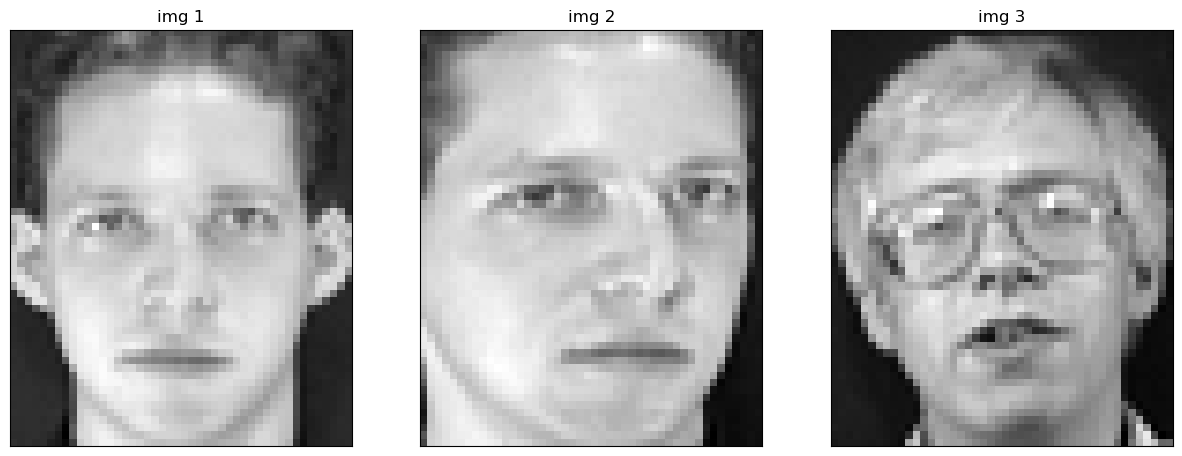

In [5]:
# Example: Ploting face image.
img = [xf[0,0], xf[0,1], xf[1,0]]
fig,axs = plt.subplots(1,3,figsize=(15,6))
axs = axs.ravel()
for i,ax in enumerate(axs.flatten()):
    ax.imshow(img[i].reshape(56,46),cmap="gray")
    ax.set_title(f"img {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

### T5. What is the Euclidean distance between xf[0,0] and xf[0,1]? What is the Euclidean distance between xf[0,0] and xf[1,0]? Does the numbers make sense? Do you think these numbers will be useful for face verification?

In [6]:
def L2_dist(x1, x2):
    """
    Calculate L2 distance.
    """
    L2 = np.sqrt(np.sum((x1-x2)**2))
    return L2

# Test L2_dist
def test_L2_dist():
    assert L2_dist(np.array([1, 2, 3]), np.array([1, 2, 3])) == 0.0
    assert  L2_dist(np.array([0, 0, 0]), np.array([1, 2, 3])) == np.sqrt(14)

test_L2_dist()

print('Euclidean distance between xf[0,0] and xf[0,1] is', L2_dist(xf[0,0], xf[0,1]))
print('Euclidean distance between xf[0,0] and xf[1,0] is', L2_dist(xf[0,0], xf[1,0]))

Euclidean distance between xf[0,0] and xf[0,1] is 10.037616294165492
Euclidean distance between xf[0,0] and xf[1,0] is 8.173295099737281


In [7]:
# the numbers don't make sense
# image[0,0] and image[0,1] -> Mr.A
# image[1,0] -> Mr.B
# distance between image[0,0] and image[0,1] should be less than distance between image[0,0] and image[1,0]

### T6. Write a function that takes in a set of feature vectors T and a set of feature vectors D, and then output the similarity matrix A. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people for list T (in order x[0, 0], x[0, 1], x[0, 2], x[1, 0], x[1, 1], ...x[39, 2]). Use the feature vectors from the remaining 7 images from all 40 people for list D (in order x[0, 3], x[0, 4], x[0, 5], x[1, 6], x[0, 7], x[0, 8], x[0, 9], x[1, 3], x[1, 4]...x[39, 9]). We will treat T as our training images and D as our testing images

In [8]:
def organize_shape(matrix):
    """
    (Optional): Reduce matrix dimension of 2D image to 1D and merge people and image dimension.
    This function can be useful at organizing matrix shapes.

    Example:
        Input shape: (people_index, image_index, image_shape[0], image_shape[1])
        Output shape: (people_index*image_index, image_shape[0]*image_shape[1])
    """
    matrix = np.reshape(matrix, (matrix.shape[0] * matrix.shape[1], matrix.shape[2] * matrix.shape[3]))
    return matrix


def generate_similarity_matrix(A, B):
    """
    Calculate similarity matrix M,
    which M[i, j] is a distance between A[i] and B[j].
    """
    similarity_matrix = np.zeros((A.shape[0],B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            similarity_matrix[i,j] = L2_dist(A[i], B[j])

    return similarity_matrix

def test_generate_similarity_matrix():
    test_A = np.array([[1, 2], [3, 4]])
    test_B = np.array([[1, 2], [5, 6], [7, 8]])
    expected_matrix = np.sqrt(np.array([[0, 32, 72], [8, 8, 32]]))
    assert (generate_similarity_matrix(test_A, test_B) == expected_matrix).all()

test_generate_similarity_matrix()

In [9]:
#Show similariry matrix between T and D.
T_mat = xf[:,:3]
D_mat = xf[:,3:]
T = organize_shape(T_mat)
D = organize_shape(D_mat)

similarity_matrix = generate_similarity_matrix(T,D)
similarity_matrix.shape

(120, 280)

### T7. From the example similarity matrix above, what does the black square between [5:10,5:10] suggest about the pictures from person number 2? What do the patterns from person number 1 say about the images from person 1?


In [10]:
# the black square is {distance = 0} that means A and B are same image
# but the patterns of distance between person A aren't black square

### T8. Write a function that takes in the similarity matrix created from the previous part, and a threshold t as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task (280 Test images, tested on 40 people, a total of 11200 testing per threshold). What is the true positive rate and the false alarm rate for t = 10?

In [11]:
def evaluate_performance(similarity_matrix, threshold):
    """
    Calculate true positive rate and false alarm rate from given similarity_matrix and threshold.
    """
    similarity_matrix = np.reshape(similarity_matrix, (40,3,similarity_matrix.shape[1]))
    min_values = np.min(similarity_matrix, axis=1)
    predict = min_values <= threshold
    predict = np.reshape(predict, (predict.shape[0],40,7))

    # confusion matrix of all face
    TP,FN,FP,TN = 0,0,0,0

    for i in range(predict.shape[0]):
        # confuson matix of face no.i
        tp = np.sum(predict[i,i,:])
        fn = predict[i,i,:].size - tp
        fp = np.sum(predict[i,:,:]) - tp
        tn = predict[i,:,:].size - predict[i,i,:].size - fp

        TP += tp
        FN += fn
        FP += fp
        TN += tn

    # true positive rate (TPR) and false alarm rate (FAR)
    true_pos_rate = TP / (TP + FN)
    false_pos_rate = FP / (FP + TN)

    return true_pos_rate, false_pos_rate

# Quick check
# (true_pos_rate, false_pos_rate) should be (0.9928571428571429, 0.33507326007326005)
evaluate_performance(similarity_matrix, 9.5)

(0.9928571428571429, 0.33507326007326005)

In [12]:
evaluate_performance(similarity_matrix, 10)

(0.9964285714285714, 0.4564102564102564)

### T9. Plot the RoC curve for this simple verification system. What should be the minimum threshold to generate the RoC curve? What should be the maximum threshold? Your RoC should be generated from at least 1000 threshold levels equally spaced between the minimum and the maximum. (You should write a function for this).

In [13]:
min_values = np.min(np.reshape(similarity_matrix, (40,3,similarity_matrix.shape[1])), axis=1)
np.max(min_values)

16.434561906764714

In [14]:
def calculate_roc(input_mat):
    """
    Calculate a list of true_pos_rate and a list of false_pos_rate from the given matrix.
    """
    tpr_list, far_list, thresh_list = [], [], []
    min_thresh, max_thresh = 0, 16.434561906764714
    num_thresh = 1000
    diff_thresh = (max_thresh - min_thresh) / num_thresh
    for i in range(num_thresh):
        thresh = (diff_thresh * i) + min_thresh
        tpr, far = evaluate_performance(input_mat, thresh)
        tpr_list.append(tpr)
        far_list.append(far)
        thresh_list.append(thresh)
    return tpr_list, far_list, thresh_list

def plot_roc(input_mat):
    """
    Plot RoC Curve from a given matrix.
    """
    tpr_list, far_list, _ = calculate_roc(input_mat)
    plt.figure()
    plt.plot(far_list, tpr_list, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


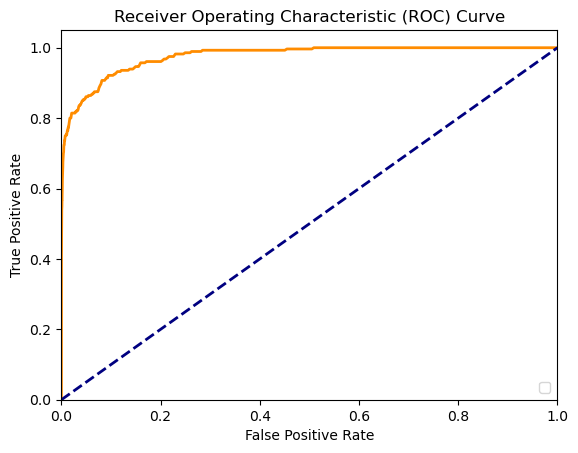

In [15]:
plot_roc(similarity_matrix)

### T10. What is the EER (Equal Error Rate)? What is the recall rate at 0.1% false alarm rate? (Write this in the same function as the previous question)



In [16]:
# You can add more parameter(s) to the function in the previous question.
tpr_list, far_list, thresh_list = calculate_roc(similarity_matrix)
tpr1, far1, threshs1 = np.array(tpr_list), np.array(far_list), np.array(thresh_list)
# EER is line that 1 - TPR = FAR 
print(tpr1[np.abs(1 - tpr1 - far1) < 1e-3])
# Recall rate
print(tpr1[tpr1 == np.max(tpr1[far1<=0.001])])
# EER should be either 0.9071428571428571 or 0.9103759398496248 depending on method.
# Recall rate at 0.1% false alarm rate should be 0.5428571428571428.

[0.91071429]
[0.54285714]


### T11. Compute the mean vector from the training images. Show the vector as an image (use numpy.reshape()). This is typically called the meanface (or meanvoice for speech signals). You answer should look exactly like the image shown below.

In [17]:
meanface = np.mean(T, axis=0)
meanface.shape

(2576,)

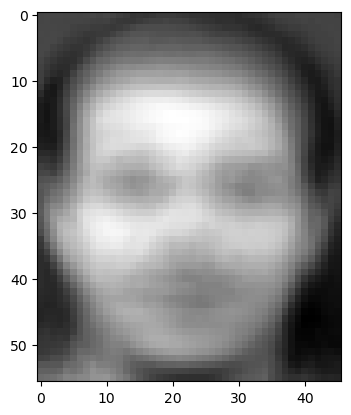

In [18]:
plt.imshow(np.reshape(meanface, (T_mat.shape[2], T_mat.shape[3])), cmap = 'gray')
plt.show()

### T12. What is the size of the covariance matrix? What is the rank of the covariance matrix?


In [19]:
# Find the size and the rank of the covariance matrix.
# image -> 56 x 46 pixel^2 = 2576 pixel
# training set -> 40 x 3 image = 120 image
# The size of the covariance matrix is 2576 × 2576 (D x D), with a rank of 119 (N-1)

### T13. What is the size of the Gram matrix? What is the rank of Gram matrix? If we compute the eigenvalues from the Gram matrix, how many non- zero eigenvalues do we expect to get?

In [20]:
gram_matrix = np.matmul(T-meanface, (T-meanface).T)
gram_matrix.shape

(120, 120)

In [21]:
# The size of the gram matrix is 120 × 120 (N x N), with a rank of 119 (N-1)

## T14. Is the Gram matrix also symmetric? Why?


In [22]:
# The Gram matrix is symmetric because each element of the matrix can be defined as a dot product between two elements
# the dot product has a commutative property, which will then allow the Gram matrix to have a symmetric propert

### T15. Compute the eigenvectors and eigenvalues of the Gram matrix, v 0 and λ. Sort the eigenvalues and eigenvectors in descending order so that the first eigenvalue is the highest, and the first eigenvector corresponds to the best direction. How many non-zero eigenvalues are there? If you see a very small value, it is just numerical error and should be treated as zero.




In [23]:
# Hint: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html

def calculate_eigenvectors_and_eigenvalues(matrix):
    """
    TODO: Calculate eigenvectors and eigenvalues,
    then sort the eigenvalues and eigenvectors in descending order.

    Hint: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
    """

    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = calculate_eigenvectors_and_eigenvalues(gram_matrix)

def test_eigenvalues_eigenvectors():
    # Dot product of an eigenvector pair should equal to zero.
    assert np.round(eigenvectors[10].dot(eigenvectors[20]), 10) == 0.0

    # Check if eigenvalues are sorted.
    assert list(eigenvalues) == sorted(eigenvalues, reverse = True)

test_eigenvalues_eigenvectors()

### T16. Plot the eigenvalues. Observe how fast the eigenvalues decrease. In class, we learned that the eigenvalues is the size of the variance for each eigenvector direction. If I want to keep 95% of the variance in the data, how many eigenvectors should I use?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


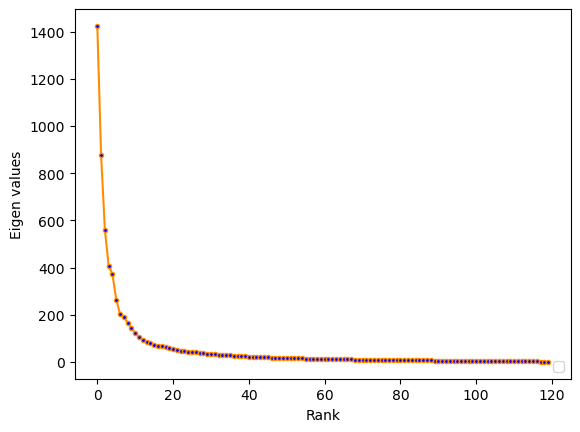

In [24]:
eigenvalues, eigenvectors = calculate_eigenvectors_and_eigenvalues(gram_matrix)
plt.figure()
plt.plot(range(len(eigenvalues)), eigenvalues, color='darkorange', marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Rank')
plt.ylabel('Eigen values')
plt.legend(loc="lower right")

In [25]:
for i in range(len(eigenvalues)):
    if 0.95 * np.sum(eigenvalues) < np.sum(eigenvalues[:i+1]):
        n_eigenvector = i+1
        print(n_eigenvector, 'eigenvectors')
        break

64 eigenvectors


### T17. Compute $\vec{v}$ . Don’t forget to renormalize so that the norm of each vector is 1 (you can use numpy.linalg.norm). Show the first 10 eigenvectors as images. Two example eigenvectors are shown below. We call these images eigenfaces (or eigenvoice for speech signals).

In [26]:
eigenvectors.shape
# (T-meanface).shape
# eigenvalues.shape
# np.matmul((T-meanface).T, eigenvectors).shape

(120, 120)

In [27]:
# Compute v, then renormalize it.
v = np.matmul((T-meanface).T, eigenvectors)/eigenvalues
v = v/np.linalg.norm(v,axis=0)
v.shape

(2576, 120)

In [28]:
def test_eignevector_cov_norm(v):
    assert (np.round(np.linalg.norm(v, axis=0), 1) == 1.0).all()

test_eignevector_cov_norm(v)

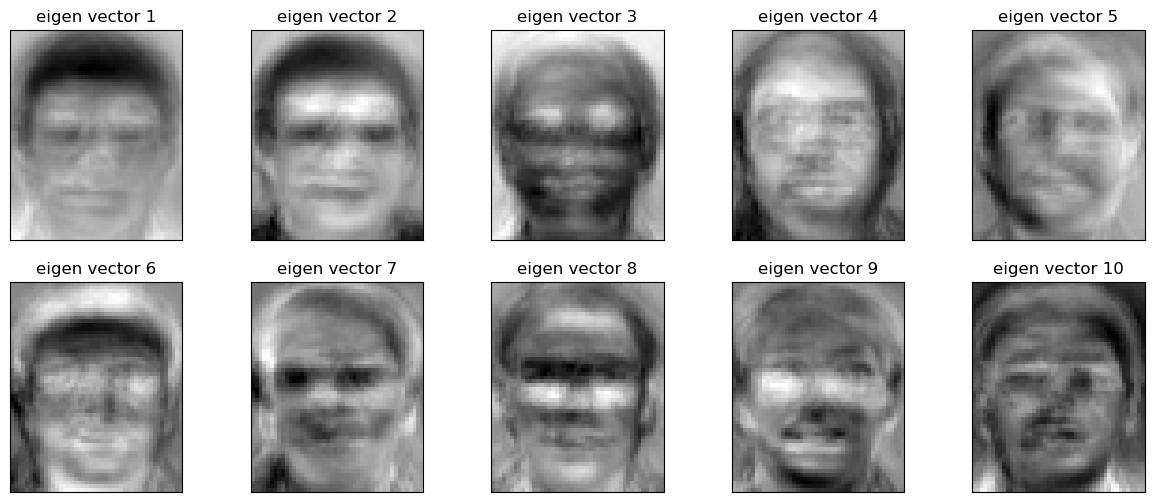

In [29]:
# Show the first 10 eigenvectors as images.
K = 10
fig,axs = plt.subplots(2,K//2,figsize=(15,6))
axs = axs.ravel()
for i,ax in enumerate(axs.flatten()):
    ax.imshow(-v[:,i].reshape(56,46),cmap="gray")
    ax.set_title(f"eigen vector {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

### T18. From the image, what do you think the first eigenvector captures? What about the second eigenvector? Look at the original images, do you think biggest variance are capture in these two eigenvectors?

In [30]:
# The first eigen face captures the person’s hair or head
# The second eigen face captures the eyes, body, and different angles on the head or hair
# Since the original image only displays the faces of people, the variance can be explained by the eigenvalue
# the first eigenvector gives the highest eigenvalue, so the biggest variance is already captured. 
# These 2 eigen vectors capture around 33.5% of the data variance
# so they still do not cover most of the data variance yet.

### T19. Find the projection values of all images. Keep the first k = 10 projection values. Repeat the simple face verification system we did earlier using these projected values. What is the EER and the recall rate at 0.1% FAR?

In [31]:
def calculate_projection_vectors(matrix, meanface, v):
    """
    Find the projection vectors on v from given matrix and meanface.
    """
    projection_vectors = np.matmul((matrix - meanface.reshape(-1,1)).T, v); #[N,D] [D,k] -> [N,k]
    return projection_vectors

In [32]:
# Get projection vectors of T and D, then Keep first k projection values.
k = 10
T_reduced = calculate_projection_vectors(T.T,meanface,v[:,:k]);
D_reduced = calculate_projection_vectors(D.T,meanface,v[:,:k]);

def test_reduce_dimension():
    assert T_reduced.shape[-1] == k
    assert D_reduced.shape[-1] == k

test_reduce_dimension()

In [33]:
# Get similarity matrix of T_reduced and D_reduced
similarity_matrix_new = generate_similarity_matrix(T_reduced,D_reduced)
similarity_matrix_new.shape

(120, 280)

In [34]:
# Find EER and the recall rate at 0.1% FAR.
# You can add more parameter(s) to the function in the previous question.
tpr_list, far_list, thresh_list = calculate_roc(similarity_matrix_new)
tpr2, far2, threshs2 = np.array(tpr_list), np.array(far_list), np.array(thresh_list)
# EER is line that 1 - TPR = FAR 
print(tpr2[np.abs(1 - tpr2 - far2) < 1e-3])
# Recall rate
print(tpr2[tpr2 == np.max(tpr2[far2<=0.001])])

[0.92142857]
[0.51071429]


### T20. What is the k that gives the best EER? Try k = 5, 6, 7, 8, 9, 10, 11, 12, 13, 14.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


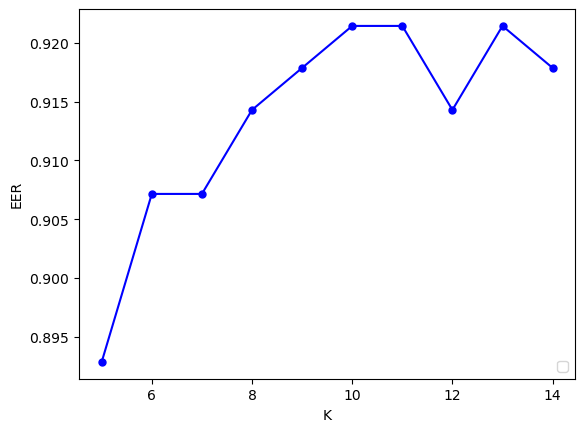

In [35]:
k_list = [5,6,7,8,9,10,11,12,13,14]
eer_list = []
for k in k_list:
    T_reduced = calculate_projection_vectors(T.T,meanface,v[:,:k]);
    D_reduced = calculate_projection_vectors(D.T,meanface,v[:,:k]);
    similarity_matrix_new = generate_similarity_matrix(T_reduced,D_reduced)
    tpr_list, far_list, thresh_list = calculate_roc(similarity_matrix_new)
    tpr, far, threshs = np.array(tpr_list), np.array(far_list), np.array(thresh_list)
    # EER is line that 1 - TPR = FAR 
    eer_list.append(tpr[np.abs(1 - tpr - far) == np.min(np.abs(1 - tpr - far))])

plt.plot(k_list, eer_list, color='blue', marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('K')
plt.ylabel('EER')
plt.legend(loc="lower right")


### T21. In order to assure that $S_W$ is invertible we need to make sure that $S_W$ is full rank. How many PCA dimensions do we need to keep in order for $S_W$ to be full rank? (Hint: How many dimensions does $S_W$ have? In order to be of full rank, you need to have the same number of linearly independent factors)

In [36]:
# We need N - C -> 120 - 40 = 80 PCA dimensions to keep in order for SW to be full rank

In [37]:
# Define dimension of PCA
n_dim = 80
# Find PCA of T and D with n_dim dimension
T_reduced = calculate_projection_vectors(T.T,meanface,v[:,:n_dim])
D_reduced = calculate_projection_vectors(D.T,meanface,v[:,:n_dim])

### T22. Using the answer to the previous question, project the original in- put to the PCA subspace. Find the LDA projections. To find the inverse, use −1 numpy.linalg.inv. Is $S_W$ $S_B$ symmetric? Can we still use numpy.linalg.eigh? How many non-zero eigenvalues are there?


In [38]:
# Find the LDA projection.
#Compute S_W and S_B;
global_mean = np.mean(T_reduced, axis=0); #[80,]

N = xf.shape[0]
T_ = np.reshape(T_reduced, (N,3,-1)); #[40,3,80]
D_ = np.reshape(D_reduced, (N,7,-1)); #[40,7,80];

local_mean = np.mean(T_, axis = 1) #[40,80]
SB = np.matmul((local_mean-global_mean).T, local_mean-global_mean)
local_mean = np.reshape(local_mean, (N,1,-1))
temp = np.reshape((T_ - local_mean), (-1,T_.shape[-1])) # [N’,3,D] -> [N’*3,D] = [N,D]
SW = np.matmul(temp.T, temp)

In [39]:
# Find how many non-zero eigenvalues there are
SW_inv = np.linalg.inv(SW)
M = np.matmul(SW_inv,SB)
eigenvalues_lda,eigenvectors_lda = np.linalg.eig(M)
eigenvalues_lda,eigenvectors_lda = np.real(eigenvalues_lda),np.real(eigenvectors_lda)
eg_sort = np.argsort(eigenvalues_lda)[::-1]
eigenvalues_lda = eigenvalues_lda[eg_sort]
eigenvectors_lda = eigenvectors_lda[:,eg_sort]

print("non-zero eigenvalues:", len(eigenvalues_lda[eigenvalues_lda > 1e-6]))

non-zero eigenvalues: 39


In [40]:
# The provided code shows that (SW^-1)(SB) is not symmetric
# we must use numpy.linalg.eig W
# because numpy.linalg.eigh is more preferable for the symmetric matrix
# and the provided code gives 39 non-zero eigenvalues

### T23. Plot the first 10 LDA eigenvectors as images (the 10 best projections). Note that in this setup, you need to convert back to the original image space by using the PCA projection. The LDA eigenvectors can be considered as a linear combination of eigenfaces. Compare the LDA projections with the PCA projections.

In [41]:
lda_eig_img = np.matmul(eigenvectors_lda, v[:,:n_dim].T) # [80,80] [80,2576]-> [80,2576]

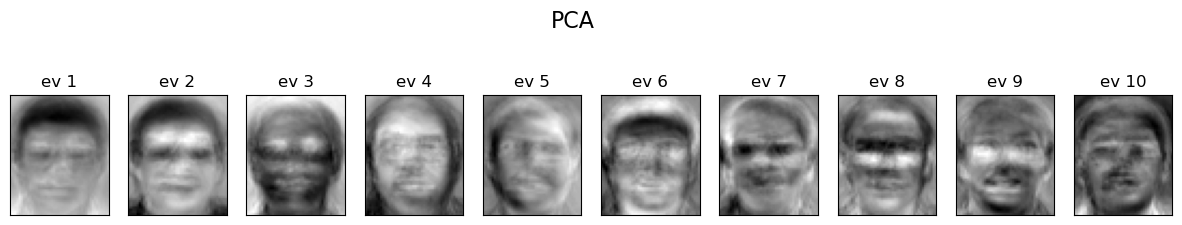

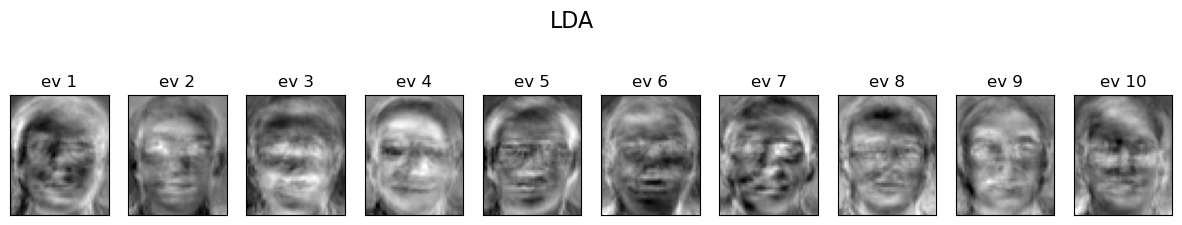

In [42]:
# Show the first 10 eigenvectors as images.
K = 10
fig,axs = plt.subplots(1,K,figsize=(15,3))
fig.suptitle('PCA', fontsize=16)
axs = axs.ravel()
for i,ax in enumerate(axs.flatten()):
    ax.imshow(-v[:,i].reshape(56,46),cmap="gray")
    ax.set_title(f"ev {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])
fig,axs = plt.subplots(1,K,figsize=(15,3))
fig.suptitle('LDA', fontsize=16)
axs = axs.ravel()
for i,ax in enumerate(axs.flatten()):
    ax.imshow(-lda_eig_img[i].reshape(56,46),cmap="gray")
    ax.set_title(f"ev {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

### T24. The combined PCA+LDA projection procedure is called fisherface. Calculate the fisherfaces projection of all images. Do the simple face verification experiment using fisherfaces. What is the EER and recall rate at 0.1% FAR?

In [43]:
pca_dim = 80
k = 10
#PCA
proj_pca_train80 = calculate_projection_vectors(T.T,meanface,v[:,:pca_dim]) #[N,D]@[D,80] -> [N,80];
proj_pca_test80 = calculate_projection_vectors(D.T,meanface,v[:,:pca_dim]) #LDA
proj_lda_train = np.matmul(proj_pca_train80, eigenvectors_lda[:,:k]) #[N,80] [80,10] -> [N,10];
proj_lda_test = np.matmul(proj_pca_test80, eigenvectors_lda[:,:k])

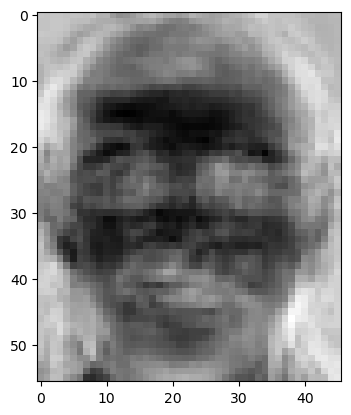

In [44]:
lda_train = np.matmul(np.matmul(proj_lda_train, eigenvectors_lda[:,:k].T), v[:,:pca_dim].T) + meanface #[120,10] [10,80] [80,2576] -> [120,2576];
lda_test = np.matmul(np.matmul(proj_lda_test, eigenvectors_lda[:,:k].T), v[:,:pca_dim].T) + meanface
plt.imshow(-lda_test[0].reshape(56,46),cmap="gray")
plt.show()

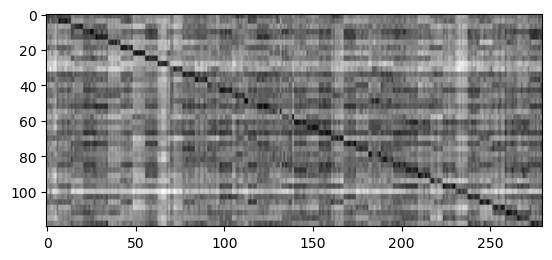

In [45]:
similarity_matrix_lda = generate_similarity_matrix(proj_lda_train,proj_lda_test)
plt.imshow(similarity_matrix_lda,cmap="gray")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


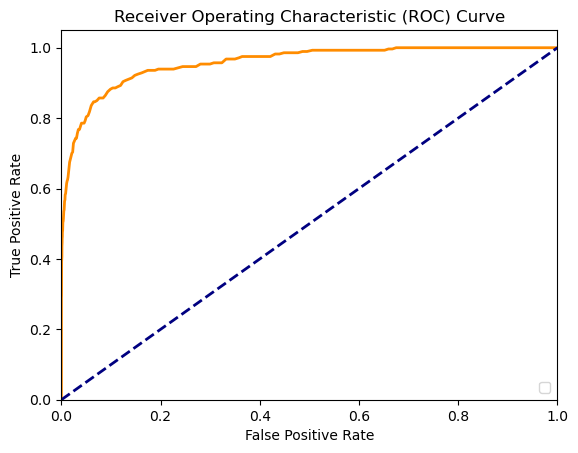

In [46]:
tpr_list, far_list, thresh_list = calculate_roc(similarity_matrix_lda)
tpr3, far3, threshs3 = np.array(tpr_list), np.array(far_list), np.array(thresh_list)
plot_roc(similarity_matrix_lda)

In [47]:
# EER is line that 1 - TPR = FAR 
print(tpr3[np.abs(1 - tpr3 - far3) < 5e-3])
# Recall rate
print(tpr3[tpr3 == np.max(tpr3[far3<=0.001])])

[0.88928571]
[0.39285714]


### T25.Plot the RoC of all three experiments (No projection, PCA, andFisher) on the same axes. Compare and contrast the three results. Submit yourwriteup and code on MyCourseVille.

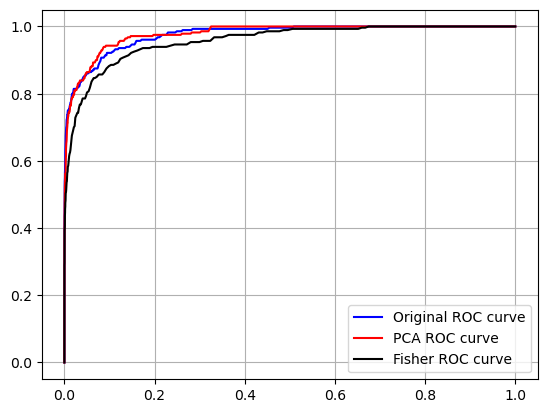

In [48]:
plt.plot(far1,tpr1,"b",label="Original ROC curve")
plt.plot(far2,tpr2,"r",label="PCA ROC curve")
plt.plot(far3,tpr3,"k",label="Fisher ROC curve")
plt.legend()
plt.grid()
plt.show()